In [1]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 
from scipy import stats

# I. Load data

In [20]:
OF = pd.read_pickle("OF_res.pkl")
DJIA = pd.read_pickle("DJIA_filled_missing_val.pkl")

# 2. Prepare dataset

In [22]:
DJIA_prim = DJIA.copy()
OF_prim = OF.drop(columns=['tweets_processed', 'tweet_size', 'positive_point', 'negative_point', 'norm_ratio'])
OF_prim = OF_prim.reset_index()
OF_prim = OF_prim.rename({'date_processed': 'Dates'}, axis=1) 

DJIA = DJIA_prim.query(' "2022-5-1" <= Dates <= "2022-6-30"').reset_index(drop=True)

OF = OF_prim.query(' "2022-05-01" <= Dates <= "2022-06-30"').reset_index(drop=True)
OF = OF.drop(columns=['Dates'])

Data = pd.concat([DJIA, OF], axis=1)

In [25]:
# Data = Data.set_index('Dates')
Data

,Close,ratio
Dates,,
2022-05-01,33040.427734,34.500000
2022-05-02,33061.500000,4.800000
2022-05-03,33128.789062,4.914286
2022-05-04,34061.058594,6.666667
2022-05-05,32997.968750,5.266667
...,...,...
2022-06-26,31453.864746,0.800000
2022-06-27,31438.259766,7.720000
2022-06-28,30946.990234,14.200000


# III. Build Neural Network model to predict DJIA
input: 
1. The past 3 days of DJIA values
2. The same combination data of our Opinion Finder mood time series (past 3 days)

Time period (in thesis): 
> Train: 2008-2-28 ~ 2008-11-28 (10 months)

> Test: 2008-12-1 ~ 2008-12-19 (19 days)

Time period (in this project): 
> Train: 2022-5-4 ~ 2022-6-10 (38 days)

> Test: 2022-6-13 ~ 2022-6-30 (17 days)


Part 1 : 只提供過去三天收盤價資訊

Single variable

> X[0]: [[ [1], [2], [3]]] 

> y[0]: [4]

<AxesSubplot:xlabel='Dates'>

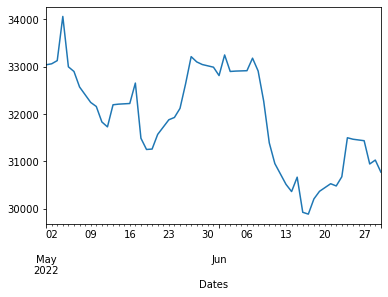

In [117]:
tmp = Data['Close']
tmp.plot()

In [118]:
tmp = tmp.to_numpy().reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
temp = scaler.fit_transform(tmp)
temp.shape

(61, 1)

In [119]:
def df_to_X_y(df, window_size=3):
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [a for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [120]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((58, 3, 1), (58, 1))

In [121]:
X_train1, y_train1 = X1[:38], y1[:38]
X_test1, y_test1 = X1[41:], y1[41:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((38, 3, 1), (38, 1), (17, 3, 1), (17, 1))

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [123]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

model1.fit(X_train1, y_train1, epochs=10)

Epoch 1/10
2/2 [==============================] - 2s 5ms/step - loss: 0.2912 - root_mean_squared_error: 0.5396
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0755 - root_mean_squared_error: 0.2748
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523
Epoch 5/10
2/2 [==============================] - 0s 17ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0279 - root_mean_squared_error: 0.1670
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0212 - root_mean_squared_error: 0.1455


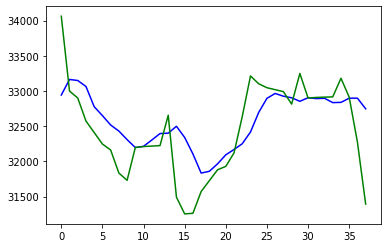

In [127]:
# train result
train_predictions = model1.predict(X_train1).flatten()
pred = scaler.inverse_transform(train_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_train1)
act = act.reshape(-1,)

train_results = pd.DataFrame(data={
    'Train Predictions':pred, 
    'Actuals':act})

plt.plot(train_results['Train Predictions'], c='b')
plt.plot(train_results['Actuals'], c='g')

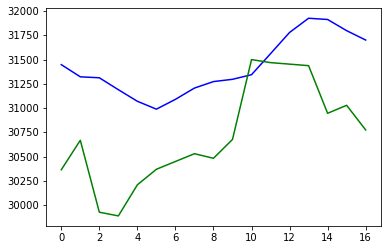

In [128]:
# Test result
test_predictions = model1.predict(X_test1).flatten()
pred = scaler.inverse_transform(test_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_test1)
act = act.reshape(-1,)

test_results = pd.DataFrame(data={
    'Test Predictions':pred, 
    'Actuals':act})

plt.plot(test_results['Test Predictions'], c='b')
plt.plot(test_results['Actuals'], c='g')

Can't predict it precisely

Part 2: 提供過去3天的DJIA + OF 資料: 

multi-variable

> X[0]: [[ [1-1, 1-2, ..], [2-1, 2-2, ...], [3-1, 3-2, ...]]]

> y[0]: [4]


# IV. Compute MAPE & Direction correct rate

In [129]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def direction(actual, pred): 
    prev_act = actual[0]
    prev_pred = pred[0]
    true = []
    res = []
    for i, j in zip(actual[1:], pred[1:]): 
        if i>=prev_act:
            true.append(1)
        else:
            true.append(-1)
        if j>=prev_pred:
            res.append(1)
        else:
            res.append(-1)
        prev_act = i
        prev_pred = j
    denorminator = len(actual) -1
    numerator = 0
    for i, j in zip(true, res):
        if i==j:
            numerator += 1
    return (numerator / denorminator)

In [130]:
# Part 1: past three days' DJIA data
print("MAPE for scenario 1: ", mape(test_results['Actuals'], test_results['Test Predictions']).round(3), "%")
print("Directional correction rate  for scenario 1:", "{0:.0%}".format(direction(test_results['Actuals'], test_results['Test Predictions'])) )

MAPE for scenario 1:  2.384 %
Directional correction rate  for scenario 1: 50%


In [ ]:
# Part 2: past three days' DJIA data + Opinion Finder data
print("MAPE for scenario 1: ", mape(test_results['Actuals'], test_results['Test Predictions']).round(3), "%")
print("Directional correction rate  for scenario 1:", "{0:.0%}".format(direction(test_results['Actuals'], test_results['Test Predictions'])) )